In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

data_dating = pd.read_csv("Speed_Dating_Data.csv", encoding="ISO-8859-1")
data_dating.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


Lets start with some data cleaning and feature selection.

For 'Field' feature there are some missing values for field_cd(coded) so we convert the field to coded values

In [5]:
data_field = data_dating[['field','field_cd']].drop_duplicates() # drop duplicates and get the coded values
data_field.dropna(inplace=True) # drop nan

index = data_dating.index
field_null = pd.isnull(data_dating['field_cd']).nonzero()[0] 
c = 0
for i in field_null:
    
    f_i = data_dating.loc[index[i], 'field']
    f_c = data_field[data_field['field']==f_i]['field_cd'].values
    
    if pd.isnull(f_c) == 0:
        # if the person did not leave 'field' empty
        c += 1
        data_dating.loc[index[i], 'field_cd'] = f_c[0]




Now we want to only select some useful features for our algorithm like gender,same race

In [6]:
useful_feature = [
     # subject data
    'iid', 'gender', 'pid', 'match', 'samerace', 'age_o', 'race_o', \
    'age', 'field_cd', 'race', 'imprace', 'imprelig', 'goal', 'date', 'go_out', 'sports',\
    #partner values
    'pf_o_att', 'pf_o_sin', 'pf_o_int','pf_o_fun', 'pf_o_amb', 'pf_o_sha',\
    #subject interests
    'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy',\
    'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',\
    #how much the subject values these features
    'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 
    #how much the subject thinks the opposite sex values feature
    'attr2_1', 'sinc2_1','intel2_1', 'fun2_1', 'amb2_1', 'shar2_1',
    #how much the subject rates him/herself
    'attr3_1', 'sinc3_1','fun3_1', 'intel3_1', 'amb3_1']

In [7]:
Data_dating = data_dating[useful_feature]

#Drop some rows with no partner idea, this can create noise in our algorithm
Data_dating = Data_dating[Data_dating.pid.notnull()]
Data_dating.head()

,iid,gender,pid,match,samerace,age_o,race_o,age,field_cd,race,...,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
0,1,0,11.0,0,0,27.0,2.0,21.0,1.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
1,1,0,12.0,0,0,22.0,2.0,21.0,1.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
2,1,0,13.0,1,1,22.0,4.0,21.0,1.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
3,1,0,14.0,1,0,23.0,2.0,21.0,1.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
4,1,0,15.0,1,0,24.0,3.0,21.0,1.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0


Now we separate the data into males and females. But, first we need to replace nan values with mean values for all the rows

In [8]:
sum([True for idx,row in Data_dating.iterrows() if any(row.isnull())])

326

In [9]:
#We replace these rows with mean
Data_dating = Data_dating.fillna(Data_dating.mean())

In [10]:
sum([True for idx,row in Data_dating.iterrows() if any(row.isnull())])

0

In [11]:
# change pid to int
Data_dating['pid'] = Data_dating['pid'].astype(int)
Data_dating['iid'] = Data_dating['iid'].astype(int)
Data_dating.head()

,iid,gender,pid,match,samerace,age_o,race_o,age,field_cd,race,...,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
0,1,0,11,0,0,27.0,2.0,21.0,1.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
1,1,0,12,0,0,22.0,2.0,21.0,1.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
2,1,0,13,1,1,22.0,4.0,21.0,1.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
3,1,0,14,1,0,23.0,2.0,21.0,1.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
4,1,0,15,1,0,24.0,3.0,21.0,1.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0


In [12]:
#separating data into males and females
male_data = Data_dating[Data_dating['gender']==1]
female_data = Data_dating[Data_dating['gender']==0]

print(male_data.shape)
print(female_data.shape)

(4184, 56)
(4184, 56)


In [13]:
# male features in combination
m_features = ['iid', 'pid', 'match', 'samerace', 'age', 'field_cd', 'race', 'imprace', 'imprelig', 'goal', 'date', 'go_out',
             'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',
             'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy',
             'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr2_1', 'sinc2_1',
             'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

In [14]:
male_data_new = male_data[m_features] # male data


In [15]:
#female features , we exclude pid match and samerace as they are redundant
m_features.remove('pid')
m_features.remove('match')
m_features.remove('samerace')

f_features = m_features

female_data_new = female_data[f_features].drop_duplicates() #our female data

Now we want to merge our dataset for males and females

In [16]:
#change the name for columns in our dataset
female_data_new.columns = [i+'_f' for i in f_features]


In [17]:
merger = pd.DataFrame()
 
for i in male_data_new.index.values:
    info = male_data_new.loc[i,:]
    pid = male_data_new.loc[i,'pid']
    ind_f = female_data_new.iid_f==pid
    if sum(ind_f) !=0:    # append only if the pid is found in female data
        info_df = female_data_new[ind_f]
        info_f = info_df.loc[info_df.index[0],:]
        combined = info.append(info_f)
        merger = merger.append(combined,ignore_index=True) 

But we need to drop feature like iid,pid,iid_f that have no relation to the outcome that is 'match'

In [18]:
drop = ['iid', 'pid', 'iid_f']
data_pair = merger.drop(drop,axis=1)
data_pair.head()

,age,age_f,amb1_1,amb1_1_f,amb2_1,amb2_1_f,art,art_f,attr1_1,attr1_1_f,...,sports,sports_f,theater,theater_f,tv,tv_f,tvsports,tvsports_f,yoga,yoga_f
0,27.0,21.0,0.0,15.0,25.0,5.0,5.0,1.0,35.0,15.0,...,8.0,9.0,4.0,1.0,2.0,9.0,7.0,2.0,1.0,1.0
1,27.0,24.0,0.0,0.0,25.0,0.0,5.0,6.0,35.0,45.0,...,8.0,3.0,4.0,9.0,2.0,1.0,7.0,2.0,1.0,1.0
2,27.0,25.0,0.0,10.0,25.0,0.0,5.0,5.0,35.0,35.0,...,8.0,3.0,4.0,7.0,2.0,8.0,7.0,8.0,1.0,7.0
3,27.0,23.0,0.0,10.0,25.0,5.0,5.0,7.0,35.0,20.0,...,8.0,1.0,4.0,9.0,2.0,7.0,7.0,1.0,1.0,8.0
4,27.0,21.0,0.0,10.0,25.0,5.0,5.0,8.0,35.0,20.0,...,8.0,7.0,4.0,6.0,2.0,8.0,7.0,4.0,1.0,3.0


Now we have our pair wise data set and we can apply learning for predicting matches

First we create label and train set from our data

In [93]:
from sklearn.model_selection import train_test_split

# create train and test data
train_data, test_data = train_test_split(data_pair, test_size=0.2, random_state=42, stratify=data_pair['match'])
predictors = [x for x in data_pair.columns if x not in ['match']]
print("train shape:", train_data.shape)
print("test shape:", test_data.shape)

train shape: (3347, 78)
test shape: (837, 78)


First we use XG Boost

In [128]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics   #Additional scklearn functions

from sklearn.model_selection import GridSearchCV   #Performing grid search



In [155]:
def modelfit(alg, dtrain,dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['match'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['match'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    #Predict test set:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report XGB")
    
    print("Train Accuracy: {0:.2f}%".format(metrics.accuracy_score(dtrain['match'].values, dtrain_predictions)*100))
    print("Test Accuracy: {0:.2f}%".format(metrics.accuracy_score(dtest['match'].values, dtest_predictions)*100))
    
    return metrics.accuracy_score(dtest['match'].values, dtest_predictions)*100
                    
    

In [156]:
clf = XGBClassifier(learning_rate =0.8,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=12,
                     gamma=0.,
                     subsample=0.85,
                     colsample_bytree=0.85,
                     reg_alpha=0.,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)


In [157]:
print("With 1000 estimators learning rate 0.8")
xgb_a1 = modelfit(clf, train_data, test_data, predictors)
xgb_a1 = round(xgb_a1,1)

With 1000 estimators learning rate 0.8

Model Report XGB
Train Accuracy: 97.40%
Test Accuracy: 80.17%


In [160]:
clf = XGBClassifier(learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=12,
                     gamma=0.,
                     subsample=0.85,
                     colsample_bytree=0.85,
                     reg_alpha=0.,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

In [161]:
print("With 1000 estimators learning rate 0.1")
xgb_a2 = modelfit(clf, train_data, test_data, predictors)
xgb_a2 = round(xgb_a2,1)

With 1000 estimators learning rate 0.1

Model Report XGB
Train Accuracy: 89.51%
Test Accuracy: 84.59%


Using Random Forest Classifier

In [114]:
from sklearn.ensemble import RandomForestClassifier
import math
clf = RandomForestClassifier(n_estimators=5, max_depth=3,random_state=0)


train_data_x = train_data[predictors]
test_data_x = test_data[predictors]
train_data_y = train_data['match']
test_data_y = test_data['match']

In [151]:
clf.fit(train_data_x, train_data_y)
RF_predictions = clf.predict(test_data_x)
print("Random Forest Model 5 estimators max_depth 3")
print("Test Accuracy: {0:.2f}%".format(metrics.accuracy_score(test_data_y, RF_predictions)*100))
RF_a1 = round(metrics.accuracy_score(test_data_y, RF_predictions)*100,1)

Random Forest Model 5 estimators max_depth 3
Test Accuracy: 81.36%


In [152]:
clf = RandomForestClassifier(n_estimators=10, max_depth=7,random_state=0)
clf.fit(train_data_x, train_data_y)
RF_predictions = clf.predict(test_data_x)
print("Random Forest Model 10 estimators max_depth 7")
print("Test Accuracy: {0:.2f}%".format(metrics.accuracy_score(test_data_y, RF_predictions)*100))
RF_a2 = round(metrics.accuracy_score(test_data_y, RF_predictions)*100,1)

Random Forest Model 10 estimators max_depth 7
Test Accuracy: 83.63%


Using Support Vector Classifier

In [146]:
from sklearn.svm import SVC
clf = SVC(kernel='poly')
clf.fit(train_data_x, train_data_y)
SVC_predictions = clf.predict(test_data_x)
print("SVC with poly kernel")
print("Test Accuracy: {0:.2f}%".format(metrics.accuracy_score(test_data_y, SVC_predictions)*100))
SVC_a1 = round(metrics.accuracy_score(test_data_y, SVC_predictions)*100,1)

SVC with poly kernel
Test Accuracy: 74.43%


In [147]:
clf = SVC(kernel='rbf')
clf.fit(train_data_x, train_data_y)
SVC_predictions = clf.predict(test_data_x)
print("SVC with rbf kernel")
print("Test Accuracy: {0:.2f}%".format(metrics.accuracy_score(test_data_y, SVC_predictions)*100))
SVC_a2 = round(metrics.accuracy_score(test_data_y, SVC_predictions)*100,1)


SVC with rbf kernel
Test Accuracy: 83.51%


Using KNN Classifier

In [148]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(train_data_x, train_data_y)
KNN_predictions = clf.predict(test_data_x)
print("KNN with 3 neighbours")
print("Test Accuracy: {0:.2f}%".format(metrics.accuracy_score(test_data_y, KNN_predictions)*100))
KNN_a1 = round(metrics.accuracy_score(test_data_y, KNN_predictions)*100,1)


KNN with 3 neighbours
Test Accuracy: 80.65%


In [149]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(train_data_x, train_data_y)
KNN_predictions = clf.predict(test_data_x)
print("KNN with 5 neighbours")
print("Test Accuracy: {0:.2f}%".format(metrics.accuracy_score(test_data_y, KNN_predictions)*100))
KNN_a2 = round(metrics.accuracy_score(test_data_y, KNN_predictions)*100,1)

KNN with 5 neighbours
Test Accuracy: 81.36%


In [175]:
import matplotlib.pyplot as plt
import numpy as np
label = ['KNN_3','KNN_5','SVC_poly','SVC_rbf', 'RandomForest_5','RandomForest_10', 'XGB_0.8','XGB_0.1']
acc_scores = [KNN_a1,KNN_a2,SVC_a1,SVC_a2,RF_a1,RF_a2,xgb_a1,xgb_a2]

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, acc_scores)
    plt.ylim(70,85)
    plt.xlabel('Models', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.xticks(index, label, fontsize=10, rotation=30)
    plt.title('Accuracy of various Models')
    plt.figure(figsize=(50,40))
    plt.show()

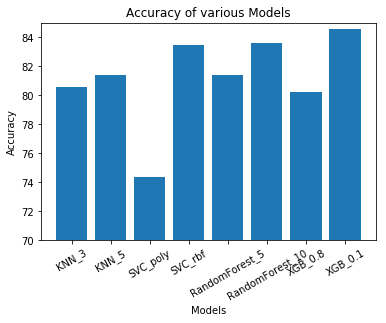

<Figure size 3600x2880 with 0 Axes>

In [176]:
plot_bar_x()